# Flowers 2.1.3

This Model using dataset from `tf_flowers` in Tensorflow Dataset.

Also, we use pre-trained `MobileNetV2` because it has 3.5M Parameter and 3.8 in Time (ms) per inference step (GPU) on Keras Application

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prepare the Data

Download and Split the data into Training, Validation and Testing.

The dataset is from tensorflow dataset named `tf_flowers`

In [ ]:
tfds.disable_progress_bar()

(train_ds, validation_ds, test_ds), ds_info = tfds.load(
    "tf_flowers",
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info = True,
    shuffle_files=False,
    as_supervised=True  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


In [ ]:
# Get the dataset structure
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [ ]:
# Get class names and how many class in dataset
class_names = ds_info.features['label'].names
class_names, len(class_names)

(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

MobileNetV2 works best with images of size `(224, 224, 3)`


`neural networks` work best with `float32 or float16` datatypes, we need to convert the uint8 datatype of the images to float32 datatype.

In [ ]:
def resize_image(image, label):
  image = tf.image.resize(image, size=(224,224))
  image = tf.cast(image, dtype = tf.float32)
  return image, label

The `num_parallel_calls` parameter in the map() function is set to `tf.data.AUTOTUNE` which automatically tunes the mapping function to increase parallel processing efficiency

In [ ]:
train_ds = train_ds.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# train_ds = train_ds.map(map_func = resize_image)
# validation_ds = validation_ds.map(map_func = resize_image)
# test_ds = test_ds.map(map_func = resize_image)

In [ ]:
# Batch the data and shuffle
batch_size = 32

train_ds = train_ds.shuffle(buffer_size=10).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


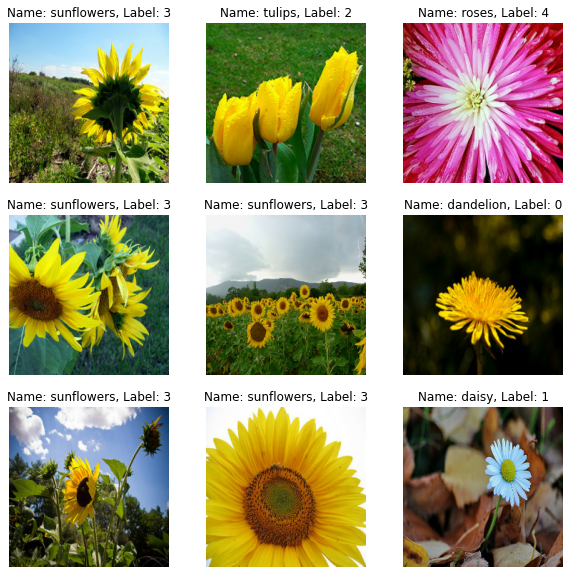

In [ ]:
# Show Image
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
      image = image/255.
      plt.subplot(3,3,i+1)
      plt.imshow(np.squeeze(image[0]))
      plt.title("Name: " + class_names[label[0].numpy()] + 
                ", Label: " + str(label[0].numpy()))
      plt.axis("off")


In [ ]:
# element_spec attribute to check the properties of the datasets
train_ds.element_spec, validation_ds.element_spec, test_ds.element_spec,

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

In [ ]:
# Random Data Augmentation 
# we use data augmentation because we only has little dataset
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), 
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomTranslation(0, 0.2), 
     keras.layers.RandomZoom(0.2, 0.2)
     ]
)


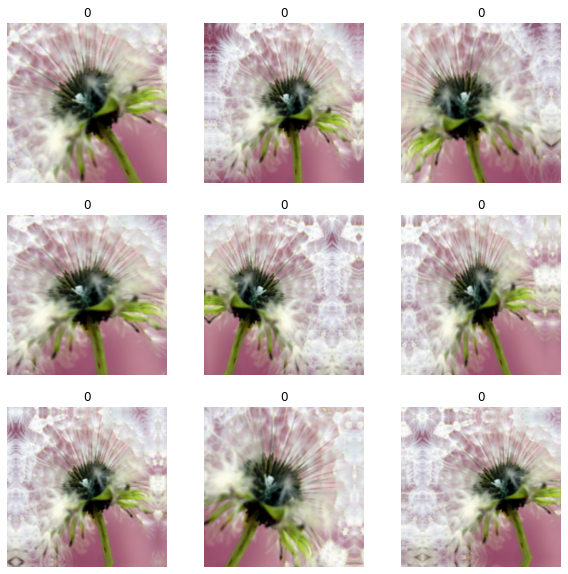

In [ ]:
# show the image after data get augmentation
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


## Callback

In [ ]:
# Make callbacks to save the best model and weight only
def model_checkpoint(directory, name):
  file_path = directory + "/" + name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=file_path,
  save_weights_only=True,
  monitor='val_accuracy',
  verbose = 1,
  save_best_only=True)

  return model_checkpoint_callback

## Build a Model

In [ ]:
base_model = keras.applications.MobileNetV2(
    # weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Freeze the base_model
base_model.trainable = False

In [ ]:

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3), name='inputLayer')
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained MobileNetV2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout to prevent overfitting
x = keras.layers.Dense(5, name='outputLayer')(x)
outputs = keras.layers.Activation(activation="softmax", 
                                  dtype=tf.float32, 
                                  name='activationLayer')(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
# Check if layers is trainable or not
for lnum, layer in enumerate(model.layers):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 inputLayer True float32 <Policy "float32">
1 sequential_1 True float32 <Policy "float32">
2 rescaling True float32 <Policy "float32">
3 mobilenetv2_1.00_224 False float32 <Policy "float32">
4 poolingLayer True float32 <Policy "float32">
5 dropout True float32 <Policy "float32">
6 outputLayer True float32 <Policy "float32">
7 activationLayer True float32 <Policy "float32">


In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
hist_model = model.fit(train_ds,
                       epochs = 10,
                       steps_per_epoch=len(train_ds),
                       validation_data=validation_ds,
                       validation_steps=int(0.1 * len(validation_ds)),
                       callbacks=[model_checkpoint("Checkpoints","model.ckpt")])

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.6369
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to Checkpoints/model.ckpt
92/92 [==============================] - 20s 75ms/step - loss: 0.9274 - accuracy: 0.6369 - val_loss: 0.4285 - val_accuracy: 0.8750
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.8134
Epoch 2: val_accuracy improved from 0.87500 to 0.93750, saving model to Checkpoints/model.ckpt
92/92 [==============================] - 5s 53ms/step - loss: 0.5119 - accuracy: 0.8134 - val_loss: 0.2953 - val_accuracy: 0.9375
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8420
Epoch 3: val_accuracy did not improve from 0.93750
92/92 [==============================] - 5s 50ms/step - loss: 0.4366 - accuracy: 0.8420 - val_loss: 0.2139 - val_accuracy: 0.9375
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.

In [ ]:
# evaluate the model in test dataset
model_results = model.evaluate(test_ds)

12/12 [==============================] - 1s 87ms/step - loss: 0.2758 - accuracy: 0.9128


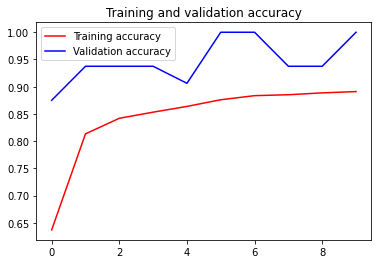

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy 
import matplotlib.pyplot as plt
acc = hist_model.history['accuracy']
val_acc = hist_model.history['val_accuracy']
loss = hist_model.history['loss']
val_loss = hist_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Fine-Tuning

In [ ]:
# Make sure the EfficeintNetB2 is trainable
base_model.trainable = True

The `BatchNormalization` layers need to be kept `frozen`. If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy 

In [ ]:
for layer in model.layers[3].layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# check if the layers is trainable or not
for lnum, layer in enumerate(model.layers[3].layers[-10:]):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 block_16_expand_BN False float32 <Policy "float32">
1 block_16_expand_relu True float32 <Policy "float32">
2 block_16_depthwise True float32 <Policy "float32">
3 block_16_depthwise_BN False float32 <Policy "float32">
4 block_16_depthwise_relu True float32 <Policy "float32">
5 block_16_project True float32 <Policy "float32">
6 block_16_project_BN False float32 <Policy "float32">
7 Conv_1 True float32 <Policy "float32">
8 Conv_1_bn False float32 <Policy "float32">
9 out_relu True float32 <Policy "float32">


In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
hist_model_tuned = model.fit(train_ds,
                             epochs=15,
                             steps_per_epoch=len(train_ds),
                             validation_data=validation_ds,
                             validation_steps=int(0.1*len(validation_ds)),
                             initial_epoch=hist_model.epoch[-1],
                             callbacks=[model_checkpoint("Checkpoints", "model_tuned.ckpt")])

Epoch 10/15
92/92 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8474
Epoch 10: val_accuracy improved from -inf to 1.00000, saving model to Checkpoints/model_tuned.ckpt
92/92 [==============================] - 27s 242ms/step - loss: 0.4294 - accuracy: 0.8474 - val_loss: 0.0618 - val_accuracy: 1.0000
Epoch 11/15
92/92 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8890
Epoch 11: val_accuracy did not improve from 1.00000
92/92 [==============================] - 21s 231ms/step - loss: 0.2911 - accuracy: 0.8890 - val_loss: 0.0511 - val_accuracy: 1.0000
Epoch 12/15
92/92 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9118
Epoch 12: val_accuracy did not improve from 1.00000
92/92 [==============================] - 21s 227ms/step - loss: 0.2341 - accuracy: 0.9118 - val_loss: 0.0794 - val_accuracy: 0.9688
Epoch 13/15
92/92 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9230
Epoch 13: val_accurac

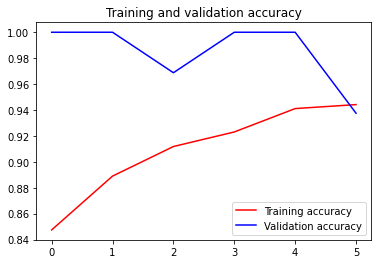

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist_model_tuned.history['accuracy']
val_acc = hist_model_tuned.history['val_accuracy']
loss = hist_model_tuned.history['loss']
val_loss = hist_model_tuned.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model_tuned_results = model.evaluate(test_ds)

12/12 [==============================] - 1s 43ms/step - loss: 0.1986 - accuracy: 0.9319


## Predict and Testing

In [ ]:
preds = model.predict(test_ds, verbose = 1)

12/12 [==============================] - 1s 42ms/step


we can easily obtain the prediction labels using the tf.argmax() function which returns the index which contains the highest probability along a given axis.

In [ ]:
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0])>

In [ ]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_labels[:10]

array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0])

In [ ]:
test_image_batches = []
for images, labels in test_ds.take(-1):
    test_image_batches.append(images.numpy())

# Step 2
test_images = [item for sublist in test_image_batches for item in sublist]
len(test_images)

367

In [ ]:
plt.figure(figsize = (20,20))
for i in range(9):
    random_int_index = random.choice(range(len(test_images)))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[random_int_index]/255.)
    if test_labels[random_int_index] == pred_labels[random_int_index]:
        color = "g"
    else:
        color = "r"
    plt.title("True Label: " + class_names[test_labels[random_int_index]] + " || " + "Predicted Label: " +
              class_names[pred_labels[random_int_index]] + "\n" + 
              str(np.asarray(tf.reduce_max(preds, axis = 1))[random_int_index]), c=color)
    plt.axis(False);

## Metrics

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, pred_labels, output_dict=True)

#check a small slice of the dictionary
import itertools
dict(itertools.islice(report.items(), 3))

{'0': {'f1-score': 0.9859154929577464,
  'precision': 0.9722222222222222,
  'recall': 1.0,
  'support': 70},
 '1': {'f1-score': 0.943089430894309,
  'precision': 0.9354838709677419,
  'recall': 0.9508196721311475,
  'support': 61},
 '2': {'f1-score': 0.8974358974358974,
  'precision': 0.9859154929577465,
  'recall': 0.8235294117647058,
  'support': 85}}

In [ ]:
f1scores = {}
for k,v in report.items():
    if k == 'accuracy':
        break
    else:
        f1scores[class_names[int(k)]] = v['f1-score']
        
#check a small slice of the dictionary
dict(itertools.islice(f1scores.items(), 5))

{'daisy': 0.943089430894309,
 'dandelion': 0.9859154929577464,
 'roses': 0.8848484848484849,
 'sunflowers': 0.9594594594594595,
 'tulips': 0.8974358974358974}

In [ ]:
F1 = pd.DataFrame({"Classes":list(f1scores.keys()),
                   "F1-Scores":list(f1scores.values())}).sort_values("F1-Scores", ascending=False)

#check a small slice of the dataframe
F1[:10]

,Classes,F1-Scores
0,dandelion,0.985915
3,sunflowers,0.959459
1,daisy,0.943089
2,tulips,0.897436
4,roses,0.884848


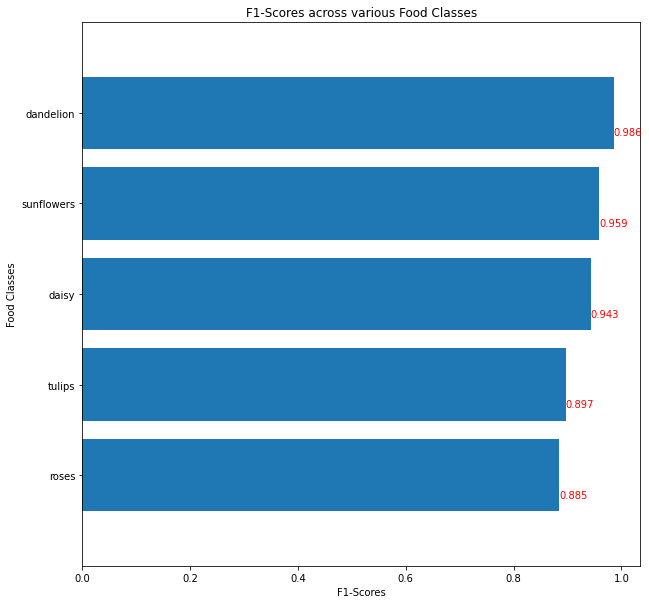

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
plt.barh(F1["Classes"], F1["F1-Scores"])
plt.ylim(-1,5)
plt.xlabel("F1-Scores")
plt.ylabel("Food Classes")
plt.title("F1-Scores across various Food Classes")
plt.gca().invert_yaxis()
for i, v in enumerate(round(F1["F1-Scores"],3)):
    ax.text(v, i + .25, str(v), color='red');

In [ ]:
Predictions = pd.DataFrame({"Image Index" : list(range(367)), 
                            "Test Labels" : list(test_labels), 
                            "Test Classes" : [class_names[i] for i in test_labels],
                            "Prediction Labels" : list(np.asarray(pred_labels)),
                            "Prediction Classes" : [class_names[i] for i in pred_labels],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(preds, axis = 1))]})

In [ ]:
Predictions["Correct Prediction"] = Predictions["Test Labels"] == Predictions["Prediction Labels"]
Predictions[:10]

,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Prediction Probability,Correct Prediction
0,0,4,roses,4,roses,0.619269,True
1,1,0,dandelion,0,dandelion,1.000000,True
2,2,0,dandelion,0,dandelion,0.984816,True
3,3,2,tulips,2,tulips,0.872582,True
4,4,0,dandelion,0,dandelion,0.999997,True
5,5,0,dandelion,0,dandelion,0.999998,True
6,6,2,tulips,2,tulips,0.999529,True
7,7,1,daisy,1,daisy,0.999907,True
8,8,3,sunflowers,3,sunflowers,1.000000,True
9,9,0,dandelion,0,dandelion,1.000000,True


In [ ]:
Predictions = Predictions[Predictions["Correct Prediction"] == False].sort_values("Prediction Probability", ascending=False)
Predictions[:10]

,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Prediction Probability,Correct Prediction
239,239,1,daisy,0,dandelion,0.999327,False
101,101,2,tulips,4,roses,0.980362,False
57,57,2,tulips,4,roses,0.970066,False
231,231,2,tulips,4,roses,0.966236,False
59,59,2,tulips,4,roses,0.954658,False
157,157,3,sunflowers,4,roses,0.935251,False
18,18,2,tulips,1,daisy,0.906089,False
90,90,2,tulips,1,daisy,0.833861,False
234,234,3,sunflowers,4,roses,0.823576,False
287,287,3,sunflowers,1,daisy,0.792065,False


## Test a Model from Capture Image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


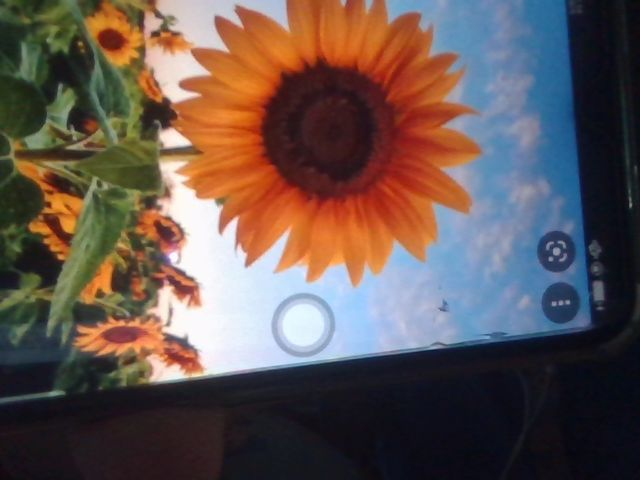

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
image_path = '/content/photo.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 40.45 percent confidence.
